In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data

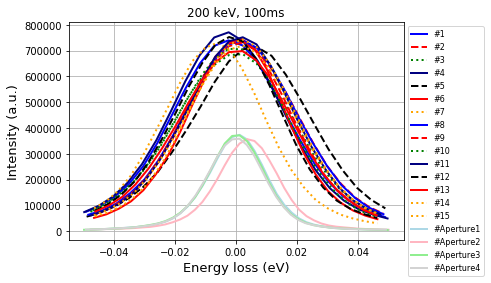

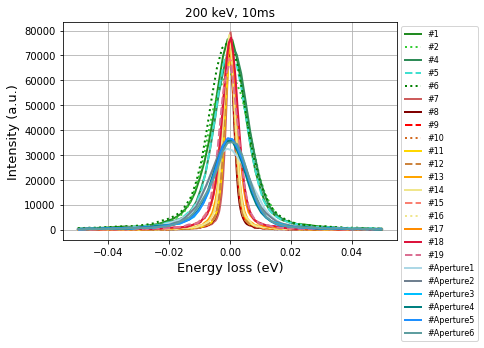

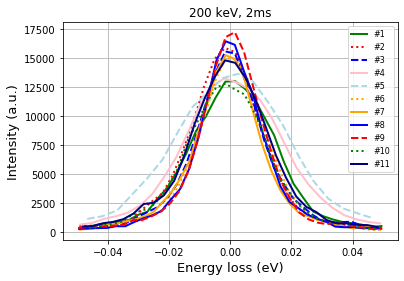


 ************************ Data files have been prepared ***************************** 



In [167]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py



### Find uncertainties on data

[32. 29. 28. 27. 34. 29. 32. 29. 31. 32. 34. 30. 31. 31. 33. 30. 31. 33.
 30. 29. 29. 31. 34. 28. 34. 31. 33. 31. 34. 35. 24. 29. 33. 31. 26. 35.
 32. 32. 28. 30. 32. 25. 30. 31. 32. 28. 32. 34. 32. 26. 35. 36. 30. 30.
 34. 35. 29. 29. 31. 29. 33. 28. 35. 30. 29. 30. 31. 32. 31. 34. 29. 35.
 29. 33. 31. 34. 31. 31. 28. 31.]


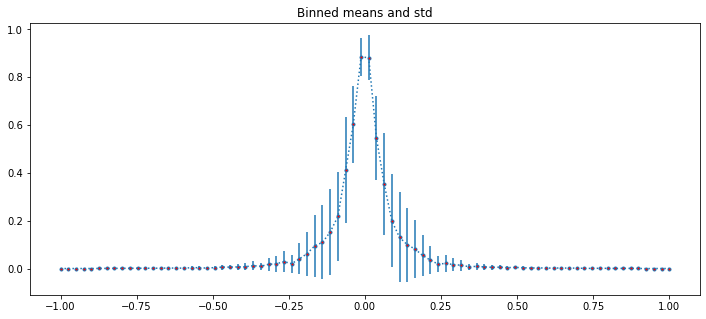

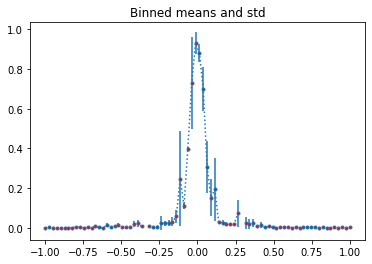

The total number of training datapoints is 2480 and validation points is 276


In [157]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

time = 10
nbins = 80
minval = -1
maxval = +1


x_train, y_train, x_val, y_val = prepare_mix_data(time)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train[:,0], mean_vector_t, variance_vector_t]
print(count_t)


# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val[:,0], mean_vector_v, variance_vector_v]


### Apply smoothing to the signal
N_train = len(df_train[:,0])
N_test = len(df_val[:,0])
smoothing_window_train = 100
smooth_y = np.array(smooth(df_train[:,1], 14))
smooth_y_test = np.array(smooth(df_val[:,1], 14))


# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
fig.set_size_inches(12, 5)
plt.show()

plot_uncertainties(x_val, y_val, nbins, minval, maxval)
fig.set_size_inches(12, 5)
plt.show()

print("The total number of training datapoints is", N_train, "and validation points is", N_test)


## Closure testing: 

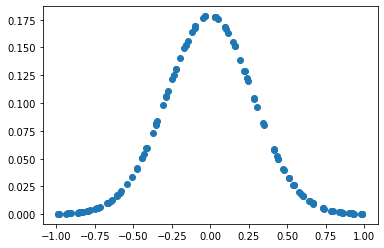

In [117]:
#amp, cen, std = 0.92042193, -0.00130338, 0.12212508 for t=10ms
#amp, cen, std = 9.23107789, -0.02310188, -0.39239466 
amp, cen, std = 0.17912820, -0.00244745, 0.27709945 #for t=2ms

y_gaus = gaussian(df_train[:,0], amp, cen, std )

plt.plot(df_train[:,0], y_gaus, 'o')

## Neural Network 

### Create architecture

In [118]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.3)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

In [119]:
tf.reset_default_graph()
from copy import copy

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train[:,0])
N_test = len(df_val[:,0])

predictions = make_model(x,1)

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 5e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, ).minimize(cost)

train_x = add_time(df_train, time)
train_sigma = df_train[:,2].reshape(N_train,1)
test_x = add_time(df_val, time)
test_sigma = df_val[:,2].reshape(N_test,1)

chi_array = []


i = 0
Nrep = 10

while i < Nrep:

    train_y = copy(df_train[:,1]).reshape(N_train,1)  ## train_y = y_gaus in case of smoothing
    train_y += np.random.normal(0, train_sigma) # Create one replica of the training set
   # train_y += np.random.normal(0, train_sigma)
    
    #print("Shape of this round of Monte Carlo replicas is:", train_y.shape)

    test_y = copy(df_train[:N_test,1]).reshape(N_test,1)
    test_y +=  np.random.normal(0, test_sigma) # Create Monte Carlo points
    test_y +=  np.random.normal(0, test_sigma)


    #print("Example of one training x, shape (,2):", train_x[80,:])
    #print("Example of one training y, shape (,1):", train_y[80])

    # Scaling input features to help the minimizer.
    train_scaler = StandardScaler()
    train_scaler.fit(train_x[:,0].reshape(1,-1))
    test_scaler = StandardScaler()
    test_scaler.fit(test_x[:,0].reshape(1,-1))

    ### Train and validate

    training_epochs = 50000
    max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
    display_step = 10000
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    predict_xx = np.linspace(-1.5, 1.5, N_train)
    predict_x = np.c_[predict_xx, 0*predict_xx+1]

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break


            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            })
    sess.close()

    # save to csv file
    from datetime import datetime
    predictions_values = predictions_values.reshape(N_train,)

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    
    chi_array.append(d[-1])

    seed = 25

    now = datetime.now()
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
   # np.savetxt('Data/Results/%(date)s.%(seed)x(a).csv' % {"date": dt_string, "seed":seed}, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
   # np.savetxt('Data/Results/%(date)s.%(seed)x(b).csv' % {"date": dt_string, "seed":seed}, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')
    print(i)
    i+=1

Start training on 0126 and validating on 0014 samples
Epoch: 0001 | Training cost= 36.556026459 | Validation cost= inf
Epoch: 10001 | Training cost= 1.497528553 | Validation cost= inf
Epoch: 20001 | Training cost= 1.335588455 | Validation cost= inf
Epoch: 30001 | Training cost= 1.333902240 | Validation cost= inf
Epoch: 40001 | Training cost= 1.326124907 | Validation cost= inf
Optimization Finished!
0
Start training on 0126 and validating on 0014 samples
Epoch: 0001 | Training cost= 113.731887817 | Validation cost= inf
Epoch: 10001 | Training cost= 1.113304973 | Validation cost= inf
Epoch: 20001 | Training cost= 1.112882257 | Validation cost= inf
Epoch: 30001 | Training cost= 1.114629865 | Validation cost= inf
Epoch: 40001 | Training cost= 1.114572048 | Validation cost= inf
Optimization Finished!
1
Start training on 0126 and validating on 0014 samples
Epoch: 0001 | Training cost= 11010.285156250 | Validation cost= inf
Epoch: 10001 | Training cost= 1.185992479 | Validation cost= inf
Epoc

### Plot outputs

[2.1644773, 16.666857, 1.9079587, 1.8908905, 2.3538475, 3.7079675, 1.829897, 2.0395741, 1.9936527, 2.036371]


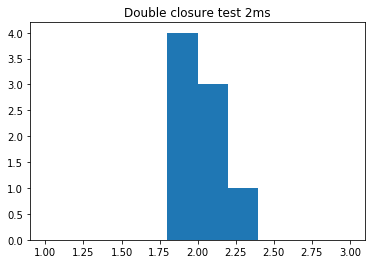

In [51]:
print(chi_array)
np.savetxt('Data/Results/Closuretest_double_2ms', chi_array, delimiter=',', fmt='%f')
plt.hist(chi_array, bins=10, range=[1, 3])
plt.title('Double closure test 2ms')
plt.savefig('Figures/Closure_double_2')
plt.show()


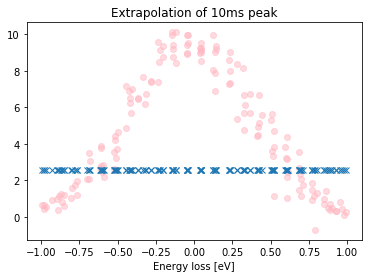

In [28]:
plt.plot(df_train[:,0], train_y, 'o', alpha=.5, color='lightpink', label='One set of MC data points')
plt.plot(df_train[:,0], predictions_values, 'x', label='$y_{pred}$')
#plot_uncertainties(x_train, y_train, nbins, minval, maxval)
#plt.legend()
plt.xlabel(r'Energy loss [eV]')

plt.title('Extrapolation of 10ms peak')
plt.savefig('Figures/Extrapolation')
plt.show()

In [ ]:
%run Evaluate_pseudodata.ipynb

#plt.plot(train_x, train_y,'o')
#plt.plot(pseudo_x, pseudo_pred, 'x', color='lightblue', label='Predictions')
plt.title('Mean for 36 replicas of 320 data points (100ms)')
pseudo_meanvector = np.linspace(-1,1,40)
plt.plot(pseudo_meanvector, pseudo10_mean, 'o', label = 'Predictions pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 40), mean_t, 'o', label='Trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(pseudo10_mean, mean_t, 'o')
plt.title('Central values')
plt.show()

In [ ]:
plt.plot(pseudo_meanvector, pseudo10_std, 'o', label = 'std pred pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 40), std_t, 'o', label='std trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,0.1,10), np.linspace(0,0.1,10), color='lightgrey')
plt.plot(pseudo10_std, std_t, 'o')
plt.title('Std')
plt.show()